# Logistic Regression

We started with basic discrete distributions for single random variables, and then we modeled pairs of categorical variables with continency tables. Here, we build models for predicting categorical responses given several explanatory variables.


In [15]:
# Setup
import torch
import matplotlib.pyplot as plt

from torch.distributions import Normal, Bernoulli


## Contingency Tables with Binary Responses

A special case of contingency table analyses is when $X \in \{1, \ldots, I\}$ corresponds to a categorical feature (e.g., to which of $I$ groups a data point belongs) and $Y \in \{0,1\}$ is a binary response. 

<!-- Contingency tables are often used to compare two groups $X \in \{0,1\}$ based on a binary response variables $Y \in \{0,1\}$. The resulting tables are 2x2. 
The association between $X$ and $Y$ can be summarized with a variety of statistics: the difference of proportions, the relative risk, and the odds ratio. We will focus on the latter.

For a Bernoulli random variable with probability $p$, the odds are defined as 
\begin{align*}
\Omega = \frac{p}{1 - p}. 
\end{align*}
Inversely, $p = \frac{\Omega}{\Omega + 1}$. -->

The corresponding tables are $I \times 2$. Normalizing each row yields a Bernoulli conditional distribution,
\begin{align*}
Y \mid X=i &\sim \mathrm{Bern}(\pi_{1|i}).
\end{align*}
where, $\pi_{1|i} = \Pr(Y=1 \mid X=i)$ or, equivalently, $\pi_{1|i} = \E[Y \mid X=i]$.

The conditional distributions are the primary objects of interest when our goal is to make predictions. They can also be used to test for independence by testing the homogeneity of conditionals.
<!-- 
To test whether $Y$ is independent of $X$, we can assess whether these conditionals are homogeneous, i.e., the same for all values of $X$. 
-->

<!-- \pi_{1|i} = \frac{\pi_{i1}}{\pi_{i0} + \pi_{i1}} = \Pr(Y=1 \mid X=i) \equiv \E[Y \mid X=i]. -->

<!-- More generally, we can write the conditional distribution for both values of $X$ as,
\begin{align*}
Y \mid X=x &\sim \mathrm{Bern}(\pi(x))
\end{align*}
where
\begin{align*}
\pi(x) 
&= \pi_{1|1} x + \pi_{1|0} (1-x) \\
&= (\pi_{1|1} - \pi_{1|0}) x + \pi_{1|0}
\end{align*}


The odds for row $i$ are,
\begin{align*}
\Omega_i = \frac{\pi_{1|i}}{1 - \pi_{1|i}} 
= \frac{\pi_{i1}}{\pi_{i0}}.
\end{align*}
The odds are non-negative, $\Omega_i \in [0, \infty)$. 

In practice, it is often more convenient to work with the log odds, $\log \Pr(Y=1 \mid X=i) = \log \Omega_i$, which are real valued.  -->



## One, Two, Many...

What if we have more than one feature, $X_1, \ldots, X_p$? We could construct a multi-dimensional contingency table to estimate the joint distribution over $(X_1,\ldots, X_p,Y)$, but we quickly encounter the curse of dimensionality: if each feature takes on $K$ values, there are $\cO(K^D)$ cells in the table.

Moreover, what if the features take on continuous values? Then the notion of a finite table no longer makes sense.

Instead, let's try to model the conditional distribution directly. Let $Y \in \{0,1\}$ denote a binary response and let $\mbX \in \reals^p$ denote associated covariates. For example, $Y$ could denote whether or not your favorite football team wins their match, and $X$ could represent features of the match like whether its a home or away game, who their opponent is, etc. We will model the conditional distribution of $Y$ given the covariates,
\begin{align*}
Y \mid \mbX = \mbx &\sim \mathrm{Bern}(\pi(\mbx))
\end{align*}
where
\begin{align*}
\pi(\mbx) &= \Pr(Y = 1 \mid \mbX=\mbx) = \E[Y \mid \mbX=\mbx].
\end{align*}

This is a standard regression setup. The modeling problem boils down to choosing the functional form of $\pi(\mbx)$. 


## Linear Regression
If you took STATS 305A, you know pretty much everything there is to know about linear regression with continuous response variables, $Y \in \reals$. Why don't we just apply that same model to binary responses? Specifically, let,
\begin{align*}
\pi(\mbx) &= \mbbeta^\top \mbx = \sum_{j=1}^p \beta_j x_j. 
\end{align*}

The obvious problem is that this linear model produces probabilities or expectations $\pi(\mbx) \in \reals$ instead of just over the valid range $[0,1]$, which is clearly misspecified!

<!-- 
Then we'll just use ordinary least squares (OLS) to estimate $\hat{\mbbeta}$. What could go wrong? After all, $\{0,1\} \subset \reals$... 

There are a few issues:
1. The linear model produces probabilities $\pi(\mbx) \in \reals$ instead of just over the valid range $[0,1]$, so the model is necessarily misspecified.
2. Moreover, the variance of a Bernoulli random variable changes as a function of the probability,
    \begin{align*}
    \Var[Y \mid \mbX=\mbx] = \pi(\mbx) (1 - \pi(\mbx)),
    \end{align*}
    which violates the homoskedasticity assumption under which OLS is optimal. 

Nevertheless, it's not a totally crazy thing to do. When the estimated probabilities are in an intermediate range (say, 0.3-0.7), the outputs aren't that different from what we obtain with the alternative models below. But we can do better. -->



## Logistic Regression

The idea is simple: keep the linear part of linear regression, but apply a **mean (aka inverse link) function**, $f: \reals \mapsto [0,1]$, to ensure $\pi(\mbx)$ returns valid probabilities,
\begin{align*}
\pi(\mbx) &= f(\mbbeta^\top \mbx).
\end{align*}
There are infinitely many squashing nonlinearities that we could choose for $f$, but a particularly attractive choice is the **logistic (aka sigmoid) function**,
\begin{align*}
f(a) = \frac{e^a}{1 + e^a} = \frac{1}{1 + e^{-a}} \triangleq \sigma(a).
\end{align*}

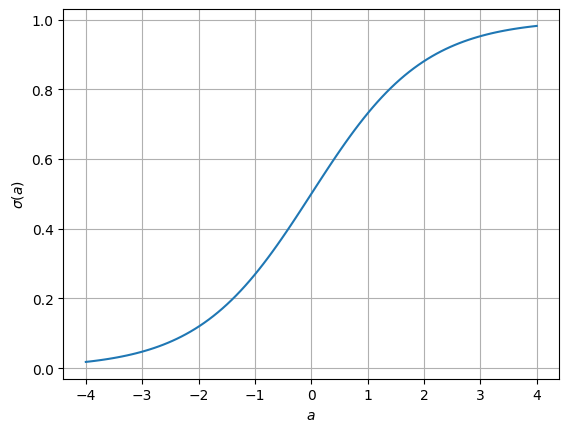

In [11]:
a = torch.linspace(-4, 4, 100)
plt.plot(a, torch.sigmoid(a))
plt.grid(True)
plt.xlabel(r"$a$")
plt.ylabel(r"$\sigma(a)$")
plt.show()

One nice feature of the logistic function is that it is monotonically increasing, so increasing in $\mbbeta^\top \mbx$ yield larger probability estimates. That also means that we can invert the sigmoid function. In doing so, we find that the linear component of the model $\mbbeta^\top \mbx$ correspond to the **log odds** of the binary response since the inverse of the sigmoid function is the **logit function**,
\begin{align*}
\mbbeta^\top \mbx = \sigma^{-1}(\pi(\mbx)) &= \log \frac{\pi(\mbx)}{1 - \pi(\mbx)}.
\end{align*}
Finally, we'll see that the logistic function leads to some simpler mathematical calculations when it comes to parameter estimation and inference.

Another common mean function is the Gaussian CDF, and we'll consider that in a later chapter. 


<!-- 
## Relationship with Two-Way Contingency Tables

Suppose we have a single, binary covariate $X \in \{0,1\}$. In the last chapter, we constructed 2x2 contingency tables for such settings, and we used the log odds ratio to measure the association between $X$ and $Y$. We could do the same thing with logistic regression.

First, we need to extend the model with an intercept term,
\begin{align*}
\pi(x) &= \sigma \left(\beta_0 + \beta_1 x \right),
\end{align*}
for $x \in \{0,1\}$.

:::{admonition} Note about intercepts
:class: warning
We explicitly separated the intercept term above, but in general we can assume that the covariates include a constant term, $\mbx = (1, x_1, \ldots, x_p)^\top \in \reals^{p+1}$. Then the first coefficient in $\mbbeta = (\beta_0, \beta_1, \ldots, \beta_p)^\top \in \reals^{p+1}$ corresponds to the intercept.
:::

Under this model, $\beta_1$ specifies the log odds,
\begin{align*}
\beta_1 = \sigma^{-1}(\pi(1)) - \sigma^{-1}(\pi(0)) 
= \log \frac{\pi(1) / (1 - \pi(1))}{\pi(0) / (1 - \pi(0))} 
= \log \theta.
\end{align*}
In other words, the coefficients of the logistic regression model correspond to the log odds in a contingency table. -->


## Hacky Parameter Estimation with OLS

How do we estimate the parameters, $\hat{\mbbeta}$? If the model were linear, then our first inclination might be to use ordinary least squares (OLS). Of course, the sigmoidal function above renders the model nonlinear, but what if we just used a Taylor approximation around the origin,
\begin{align*}
\sigma(a) &\approx \sigma(0) + \sigma'(0) a 
= \frac{1}{2} + \frac{a}{4}
\end{align*}

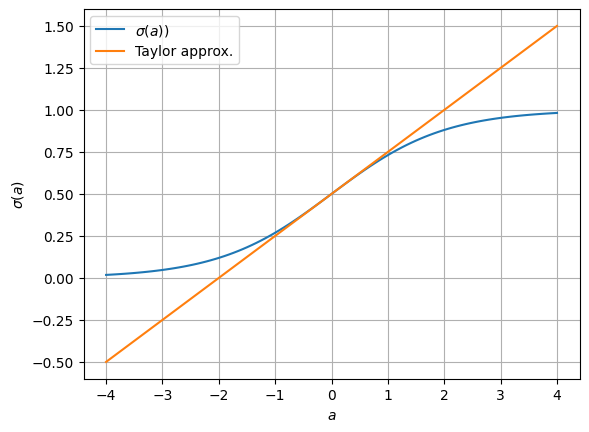

In [14]:
plt.plot(a, torch.sigmoid(a), label=r"$\sigma(a)$)")
plt.plot(a, 0.5 + 0.25 * a, label="Taylor approx.")
plt.grid(True)
plt.xlabel(r"$a$")
plt.ylabel(r"$\sigma(a)$")
plt.legend()
plt.show()

Then under this model,
\begin{align*}
\E[Y \mid \mbX=\mbx] 
&\approx \frac{1}{2} + \frac{\mbbeta^\top \mbx}{4} 
\end{align*}
or equivalently,
\begin{align*}
\E[Z \mid \mbX=\mbx] 
&\approx \mbbeta^\top \mbx
\end{align*}
where $Z = 4 (Y - \tfrac{1}{2}) \in \{-2, +2\}$ is an adjusted response variable. 

Given a set of $n$ observations of features and (adjusted) responses, $\{\mbx_i, z_i\}_{i=1}^n$, the OLS estimate is,
\begin{align*}
\hat{\mbbeta}_{\textsf{OLS}} &= \left( \sum_{i=1}^n \mbx_i \mbx_i^\top \right)^{-1} \left(\sum_{i=1}^n \mbx_i z_i \right)
\end{align*}

### Demo

Let's try it out for a simulated dataset with scalar covariates $X_i \sim \mathrm{N}(0,1)$. We'll simulate responses $Y_i \mid X_i = x_i \sim \mathrm{Bern}(\sigma(\beta^* x_i))$ for a few values of $\beta^*$.

In [38]:
def sample_and_fit_ols(seed, n, beta_true):
    torch.manual_seed(seed)
    X = Normal(0, 1.0).sample((n,))                   # covariates
    Y = Bernoulli(logits=X * beta_true).sample()    # binary outcomes

    # Fit OLS
    Z = 4 * (Y - 0.5)
    beta_ols = torch.sum(X * Z) / torch.sum(X ** 2)
    return X, Y, beta_ols

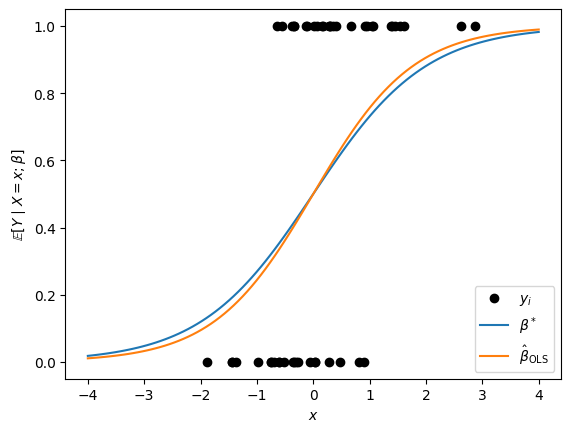

In [87]:
# Generate, fit, and plot a synthetic dataset
seed = 305+ord("b")
n = 50
beta_true = 1.0
X, Y, beta_ols = sample_and_fit_ols(seed, n, beta_true)

xs = torch.linspace(-4, 4, 100)
plt.plot(X, Y, "ko", label=r"$y_i$")
plt.plot(xs, torch.sigmoid(xs * beta_true), label=r"$\beta^*$")
plt.plot(xs, torch.sigmoid(xs * beta_ols), label=r"$\hat{\beta}_{\mathsf{OLS}}$")
plt.xlabel(r"$x$")
plt.ylabel(r"$\mathbb{E}[Y \mid X=x; \beta]$")
plt.legend(loc="lower right")

Not too shabby! Let's try it with a bunch of simulated datasets.

Text(0, 0.5, 'Density')

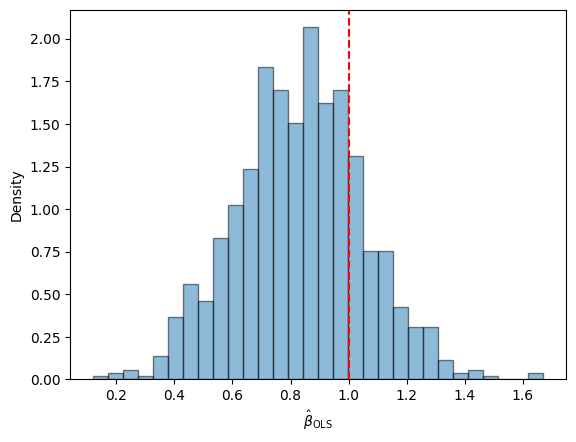

In [66]:
beta_olss = [sample_and_fit_ols(seed, n, beta_true)[-1] for seed in range(1000)]

plt.hist(beta_olss, bins=30, density=True, alpha=0.5, edgecolor="k")
plt.axvline(beta_true, color="r", linestyle="--", label=r"$\beta^*$")
plt.xlabel(r"$\hat{\beta}_{\mathsf{OLS}}$")
plt.ylabel("Density")

It looks a bit biased, but it's not terrible. 

What if we try for other values of $\beta^*$?

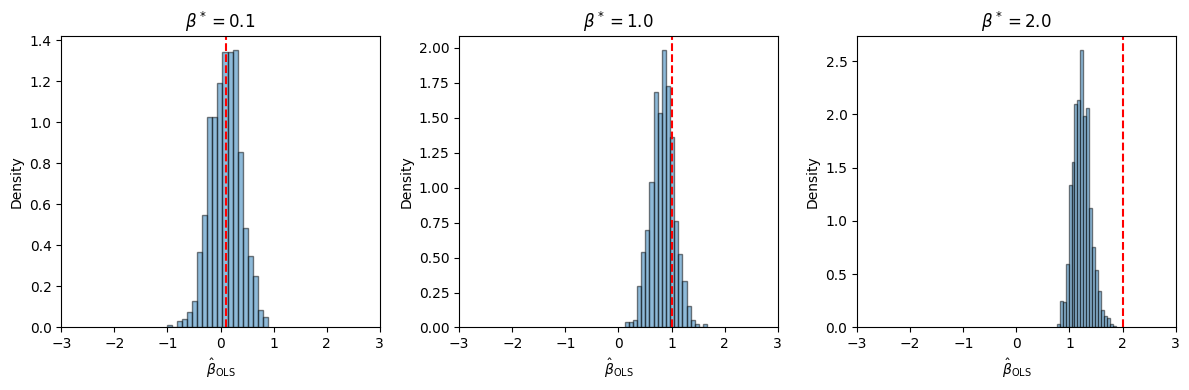

In [83]:
n = 50

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for ax, beta_true in zip(axs, [0.1, 1.0, 2.0]):
    beta_olss = [sample_and_fit_ols(seed, n, beta_true)[-1] for seed in range(1000)]

    ax.hist(beta_olss, bins=20, density=True, alpha=0.5, edgecolor="k")
    ax.axvline(beta_true, color="r", linestyle="--", label=r"$\beta^*$")
    ax.set_xlabel(r"$\hat{\beta}_{\mathsf{OLS}}$")
    ax.set_xlim(-3, 3)
    ax.set_ylabel("Density")
    ax.set_title(rf"$\beta^* = {beta_true}$")
plt.tight_layout()

Uh oh... 😬 

:::{admonition} Question
:class: tip

Why do you think the OLS estimator becomes more biased as $\beta^*$ grows?
::: 

## Maximum Likelihood Estimation

Let's try a more principled approach: maximum likelihood estimation. For standard linear regression with independent Gaussian responses and homoskedastic noise, $\hat{\mbbeta}_{\mathsf{MLE}} = \hat{\mbbeta}_{\mathsf{OLS}}$. Unfortunately, for logistic regression, there isn't a closed form for $\hat{\mbbeta}_{\mathsf{MLE}}$. However, we can use standard optimization techniques to compute it.

There are plenty of standard implementations of maximum likelihood estimation for logistic regression models. Let's see how scikit-learn's implementation fares on the simulated datasets above.

### Demo

In [84]:
from sklearn.linear_model import LogisticRegression

def sample_and_fit_mle(seed, n, beta_true):
    torch.manual_seed(seed)
    X = Normal(0, 1.0).sample((n,))                   # covariates
    Y = Bernoulli(logits=X * beta_true).sample()      # binary outcomes

    # Fit MLE
    beta_mle = LogisticRegression().fit(X.reshape(-1, 1), Y).coef_[0, 0]
    return X, Y, beta_mle

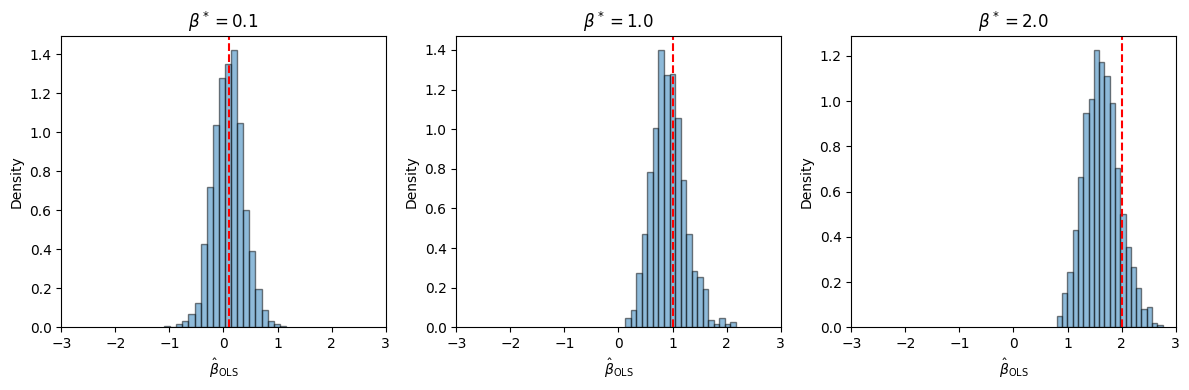

In [85]:
n = 50 

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for ax, beta_true in zip(axs, [0.1, 1.0, 2.0]):
    beta_mles = [sample_and_fit_mle(seed, n, beta_true)[-1] for seed in range(1000)]

    ax.hist(beta_mles, bins=20, density=True, alpha=0.5, edgecolor="k")
    ax.axvline(beta_true, color="r", linestyle="--", label=r"$\beta^*$")
    ax.set_xlabel(r"$\hat{\beta}_{\mathsf{OLS}}$")
    ax.set_xlim(-3, 3)
    ax.set_ylabel("Density")
    ax.set_title(rf"$\beta^* = {beta_true}$")
plt.tight_layout()

Much better!

:::{admonition} Exercise
:class: tip

Try fitting the MLE for different numbers of data points, $n$. Is it asymptotically biased?
::: 

### Deriving the MLE

Maximizing the likelihood is equivalent to minimizing the (average) negative log likelihood for a collection of covariates and responses, $\{\mbx_i, y_i\}_{i=1}^n$,
\begin{align*}
\cL(\mbbeta) 
&= - \frac{1}{n} \sum_{i=1}^n \log \mathrm{Bern}(y_i; \pi(\mbx_i)) \\
&= - \frac{1}{n} \sum_{i=1}^n y_i \log \pi(\mbx_i) + (1 - y_i) \log (1 - \pi(\mbx_i)) \\
&= - \frac{1}{n} \sum_{i=1}^n y_i \log \frac{\pi(\mbx_i)}{1 - \pi(\mbx_i)} + \log (1 - \pi(\mbx_i)).
\end{align*}
Now let's plug in the definition of $\pi(\mbx)$. The first term is just the log odds, which we already showed is equal to $\mbbeta^\top \mbx$, the linear component of the model. The second term simplifies too.
\begin{align*}
\cL(\mbbeta) 
&= - \frac{1}{n} \sum_{i=1}^n \left[y_i \mbbeta^\top \mbx_i + \log \left(1 - \frac{e^{\mbbeta^\top \mbx_i}}{1 + e^{\mbbeta^\top \mbx_i}} \right) \right] \\
&= - \frac{1}{n} \sum_{i=1}^n \left[y_i \mbbeta^\top \mbx_i - \log \left(1 + e^{\mbbeta^\top \mbx_i} \right) \right].
\end{align*}



### Computing the Gradient
We want to maximize the log likelihood, which is of course equivalent to minimizing the negative log likelihood, so let's take the gradient,
\begin{align*}
\nabla \cL(\mbbeta) 
&= -\frac{1}{n} \sum_{i=1}^n \left(y_i \mbx_i - \frac{e^{\mbbeta^\top \mbx_i}}{1 + e^{\mbbeta^\top \mbx_i}} \mbx_i \right) \\
&= -\frac{1}{n}  \sum_{i=1}^n \left(y_i - \sigma(\mbbeta^\top \mbx_i) \right) \mbx_i.
\end{align*}
Thus, the gradient is a weighted sum of the covariates, and the weights are the residuals $y_i - \sigma(\mbx_i^\top \mbbeta)$, i.e., the difference between the observed and expected response. 

This is pretty intuitive! Remember that the gradient points in the direction of steepest descent. This tells us that to increase the log likelihood the most (equivalently, decrease $\cL$ the most), we should move the coefficient in the direction of covariates where the residual is positive (we are underestimating the mean), and we should move opposite the direction of covariates where the residual is negative (where we are overestimating the mean). 

Now that we have a closed-form expression for the gradient, we can implement a simple gradient descent algorithm to minimize the negative log likelihood,
\begin{align*}
\mbbeta_{t+1} &\leftarrow \mbbeta_t - \alpha_t \nabla \cL(\mbbeta_t),
\end{align*}
where $\alpha_t \in \reals_+$ is the step-size at iteration $i$ of the algorithm. If the step sizes are chosen appropriately and the objective is well behaved, the alorithm converges to at least a local optimum of the log likelihood. 



### Convexity of the Log Likelhood

If the objective is convex, then all local optima are also global optima, and we can give stronger guarantees on gradient descent. To check the convexity of the log likelihood, we need to compute its Hessian,
\begin{align*}
\nabla^2 \cL(\mbbeta) 
&= \frac{1}{n} \sum_{i=1}^n \sigma'(\mbbeta^\top \mbx_i) \mbx_i \mbx_i^\top
\end{align*}
where $\sigma'(a)$ is the derivative of the logistic function. That is,
\begin{align*}
\sigma'(a) 
&= \frac{\dif}{\dif a}  \sigma(a)\\
&= \frac{e^a}{(1+e^a)^2} \\
&= \sigma(a) (1 - \sigma(a)).
\end{align*}
Plugging this in,
\begin{align*}
\nabla^2 \cL(\mbbeta) 
&= \frac{1}{n} \sum_{i=1}^n \sigma(\mbbeta^\top \mbx_i)(1 - \sigma(\mbbeta^\top \mbx_i)) \mbx_i \mbx_i^\top \\
&= \frac{1}{n} \sum_{i=1}^n w_i \mbx_i \mbx_i^\top,
\end{align*}
where the weights are, $w_i = \sigma(\mbbeta^\top \mbx_i)(1 - \sigma(\mbbeta^\top \mbx_i)) = \Var[Y \mid \mbX = \mbx_i]$. 
In other words, the Hessian is a weighted sum of outer products of covariates where the weights are equal to the conditional variance. 
Since variances are non-negative, so are the weights, which implies that the Hessian is **positive semi-definite**, which implies that the negative log likelihood is convex.



### Example

As an example, let's plot the negative log likelihood for a scalar covariate example, as above.


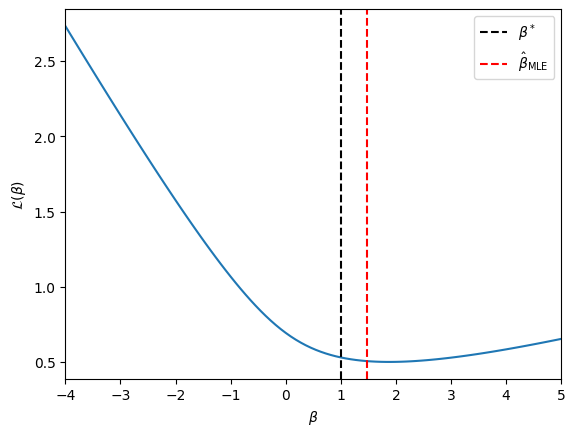

In [96]:
seed = 305+ord("b")
n = 50
beta_true = 1.0
X, Y, beta_mle = sample_and_fit_mle(seed, n, beta_true)

betas = torch.linspace(-4, 5, 100)
nlls = -Bernoulli(logits=X[:, None] * betas[None, :]).log_prob(Y[:, None]).mean(axis=0)
plt.plot(betas, nlls)
plt.axvline(beta_true, color="k", linestyle="--", label=r"$\beta^*$")
plt.axvline(beta_mle, color="r", linestyle="--", label=r"$\hat{\beta}_{\mathsf{MLE}}$")
plt.xlabel(r"$\beta$")
plt.xlim(betas[0], betas[-1])
plt.ylabel(r"$\mathcal{L}(\beta)$")
plt.legend(loc="upper right")
plt.show()


## Regularization



### Pathologies in the Separable Regime

Suppose the two classes are _linearly separable_, 
\begin{align*}
\exists \mbu \in \bbS_{p-1} \text{ s.t. } 
\begin{cases}
\mbu^\top \mbx_i > 0 & \text{ if } y_i = 1 \\
\mbu^\top \mbx_i < 0 &\text{ if } y_i = 0
\end{cases}
\end{align*}
Now let $\mbbeta = c \mbu$ for any $c \in \reals_+$. We have 
\begin{align*}
\lim_{c \to \infty} \sigma(c \mbu^\top \mbx_i) &= y_i.
\end{align*}
In this limit, the model is saturated: $\Pr(y_i \mid \mbx_i) = 1$ for all $i=1,\ldots,n$; the negative log likelihood goes to $\lim_{c \to \infty} \cL(c \mbu) = 0$; and the MLE does not exist since $\mbbeta^\star$ diverges. 

If we run gradient descent in this setting, the magnitude of the estimate $\hat{\mbbeta}$ will grow without bound, but the objective should converge to zero. Nevertheless, the diverging MLE is problematic for our convergence rate analysis, since it depends on the norm $\|\mbbeta^\star - \mbbeta_0\|_2^2$. 


### $L_2$-Regularization

These pathologies can be averted with a little regularization,
\begin{align*}
\cL(\mbbeta) 
&= - \frac{1}{n} \sum_{i=1}^n \log \mathrm{Bern}(y_i; \sigma(\mbbeta^\top \mbx_i)) + \textcolor{red}{\frac{\gamma}{2} \|\mbbeta\|_2^2}.
\end{align*}
The regularizer penalizes larger values of the weights, $\mbbeta$, and the **hyperparameter** $\gamma \in \reals_+$ sets the strength of the penalty. Even in the linearly separable regime, the maximizer is finite.

Now, the gradient and Hessian are,
\begin{align*}
\nabla \cL(\mbbeta) 
&= -\frac{1}{n}  \sum_{i=1}^n \left(y_i - \sigma(\mbx_i^\top \mbbeta) \right) \mbx_i \textcolor{red}{+ \gamma \mbbeta} \\
\nabla^2 \cL(\mbbeta) 
&= \frac{1}{n} \sum_{i=1}^n w_i \mbx_i \mbx_i^\top \textcolor{red}{+ \gamma \mbI}. 
\end{align*}


### Choosing the Hyperparameter
It remains to select a value of $\gamma$. There are many ways to do so. One approach is to _not_ choose a single value and instead try to compute the **regularization path**; i.e., the solution $\hat{\mbbeta}(\gamma)$ for a range of $\gamma \in [0, \infty)$.  Another is to hold out a fraction of data and use cross-validation to select the hyperparameter setting that yields the best performance on the held-out data.  




### Bayesian Perspective
From a Bayesian perspective, we can think of the regularizer as a **prior log probability**. In the case above, the regularizer corresponds to a spherical Gaussian prior,
\begin{align*}
\mbbeta &\sim \mathrm{N}(\mbzero, (\gamma n)^{-1} \mbI),
\end{align*}
where **precision (inverse covariance)** $\gamma n \mbI$.  Minimizing the objective above corresponds to doing **maximum a posteriori (MAP)** estimation in the Bayesian model. If you are going to take a Bayesian stance, it's a bit strange to summarize the entire posterior by its mode, though. We are interested in the posterior distribution as a whole. At the very least, we'd like to know the variance around the mode. We'll talk more about Bayesian methods in the coming weeks.


## Newton's Method
Gradient descent leverages the gradient at $\mbbeta$ to determine the update. Newton's method uses the Hessian to inform the update as well, and in doing so it can achieve considerably faster convergence.

The second order Taylor approximation of $\cL$ around $\mbbeta$ is 
\begin{align*}
\cL(\mbbeta') \approx \cL(\mbbeta) + \nabla \cL(\mbbeta)^\top (\mbbeta' - \mbbeta) + \frac{1}{2} (\mbbeta' - \mbbeta)^\top \nabla^2 \cL(\mbbeta) (\mbbeta' - \mbbeta) \triangleq \widetilde{\cL}(\mbbeta')
\end{align*}
The stationary point of $\widetilde{\cL}(\mbbeta')$ is at 
\begin{align*}
\nabla \widetilde{\cL}(\mbbeta') &= \nabla \cL(\mbbeta) + \nabla^2 \cL(\mbbeta) (\mbbeta' - \mbbeta) = 0 \\
\implies \mbbeta' &= \mbbeta - [\nabla^2 \cL(\mbbeta)]^{-1} \nabla \cL(\mbbeta),
\end{align*}
assuming the Hessian is invertible. When $\nabla^2 \cL(\mbbeta) \succ 0$ &mdash; i.e., when the Hessian is positive definite &mdash; the inverse Hessian exists and the stationary point is a minimizer. 

The vanilla Newton's method applies this update repeatedly until convergence, forming a quadratic approximation and then minimizing it. _Damped_ Newton's method adds a step size $\alpha_t < 1$ to improve stability, 
\begin{align*}
\mbbeta_{t+1} &\leftarrow \mbbeta_t - \alpha_t [\nabla^2 \cL(\mbbeta_t)]^{-1} \nabla \cL(\mbbeta_t),
\end{align*}
and the step size can be chosen by backtracking line search, for example. 

:::{admonition} Question
Compare the Newton update to that of gradient descent. How do they differ? 
:::



## Iteratively Reweighted Least Squares

Newton's method solves for the minimum of a quadratic approximation to the loss function at each iteration. What else involves minimizing a quadratic loss function? Least squares. It turns out that Newton's method can be viewed as iteratively solving a weighted least squares problem. To see this, Let's first write the gradient and Hessian in matrix form,
\begin{align*}
\nabla \cL(\mbbeta_t) &= -\frac{1}{n} \mbX^\top (\mby - \hat{\mby}_t) \\
\nabla^2 \cL(\mbbeta_t) &= \frac{1}{n} \mbX^\top \mbW_t \mbX
\end{align*}
where 
- $\mbX \in \reals^{n \times p}$ is the design matrix with rows $\mbx_i^\top$
- $\mby \in \{0,1\}^n$ is the vector of binary responses
- $\hat{\mby}_t = \sigma(\mbX \mbbeta_t) \in [0,1]^n$ is the vector of predicted response means
- $\mbW_t = \diag([w_{t,1}, \ldots, w_{t,n}])$ with $w_{t,i} = \sigma(\mbx_i^\top \mbbeta_t) (1- \sigma(\mbx_i^\top \mbbeta_t))$ is the diagonal weight matrix, where the weights are given by the conditional variances.

Then the (undamped) Newton update is,
\begin{align*}
\mbbeta_{t+1} 
&= \mbbeta_t - [\nabla^2 \cL(\mbbeta_t)]^{-1} \nabla \cL(\mbbeta_t) \\
&= \mbbeta_t + [\mbX^\top \mbW_t \mbX]^{-1} \mbX^\top (\mby - \hat{\mby}_t) \\
&= [\mbX^\top \mbW_t \mbX]^{-1} \mbX^\top \mbW_t \mbX \mbbeta_t + [\mbX^\top \mbW_t \mbX]^{-1} \mbX^\top (\mby - \hat{\mby}_t) \\
&= [\mbX^\top \mbW_t \mbX]^{-1} \mbX^\top \mbW_t \mbz_t
\end{align*}
where 
\begin{align*}
\mbz_t &= \mbX \mbbeta_t + \mbW_t^{-1} (\mby - \hat{\mby}_t).
\end{align*}
We recognize the update the update above as the solution to a **weighted least squares** problem with **weights** $w_{t,i}$ and **adjusted (or working) responses** $z_{t,i}$.

How can we interpret the working responses? We can view them as the real responses mapped through a Taylor approximation of the link (inverse mean) function,
\begin{align*}
\sigma^{-1}(y_i) 
&\approx \sigma^{-1}(\hat{y}_{t,i}) + (y_i - \hat{y}_{t,i}) [\sigma^{-1}]'(\hat{y}_{t,i}) \\
&= \mbx_i^\top \mbbeta_t + \frac{(y_i - \hat{y}_{t,i})}{w_{t,i}} \\
&\triangleq z_{t,i}.
\end{align*}




## Asymptotic Covariance of MLE

What other insight can we glean from the Hessian? Recall our discussion of the asymptotic normality of the MLE from [Lecture 1](01_distributions.ipynb). For iid observations $Y_i \iid{\sim} p(\cdot; \mbtheta)$ for $i=1,\ldots,n$, the asymptotic covariance is $\cI(\mbtheta)^{-1} / n$, where
\begin{align*}
\cI(\mbtheta)= -\E[\nabla_{\mbtheta}^2 \log p(Y; \mbtheta)]
\end{align*} 
is the Fisher information matrix. 

For logistic regression, we have $n$ independent but _not_ identically distributed observations. In this case, the asymptotic covariance follows the same form. It is given by the inverse of the Fisher information matrix; i.e., the inverse of the negative expected Hessian of the log likelihood,
\begin{align*}
\cI(\mbbeta) = -\sum_{i=1}^N \E[\nabla_{\mbbeta}^2 \log p(Y_i \mid \mbX_i=\mbx_i; \mbbeta)].
\end{align*}
(Note that this includes the iid formula as a special case.)

Substituting the form of the Hessian from above,
\begin{align*}
\cI(\mbbeta)
&= \sum_{i=1}^n \E[\Var[Y_i \mid \mbX = \mbx_i] \mbx_i \mbx_i^\top] \\
&= \sum_{i=1}^n w_i \mbx_i \mbx_i^\top 
\end{align*}
where $w_i = \sigma(\mbbeta^\top \mbx_i) (1 - \sigma(\mbbeta^\top \mbx_i))$. Finally, we evaluate the Fisher information the MLE to obtain the asymptotic covariance estimate,
\begin{align*}
\widehat{\Cov}(\hat{\mbbeta}) &= [\cI(\hat{\mbbeta})]^{-1}.
\end{align*}

Like before, we can use the asymptotic covariance estimate to derive Wald confidence intervals for the parameters and perform hypothesis tests. 


:::{admonition} Caution
:class: warning
Remember, Wald confidence intervals are only as good as the asymptotic normality assumption. When the likelihod is not well approximated by a quadratic, the covariance estimate will be poor, and the confidence intervals will be invalid. When might the Gaussian approximation not hold?
:::


<!-- ## Bayesian Inference with the Laplace Approximation

Finally, suppose you wanted to perform Bayesian inference of the weights under a Gaussian prior,
\begin{align*}
\mbbeta &\sim \mathrm{N}(\mbzero, \gamma^{-1} \mbI).
\end{align*}
Unfortunately, the posterior does not have a closed formation solution. Instead, a common form of approximate posterior inference is the **Laplace approximation**,
\begin{align*}
p(\mbbeta \mid \mbX, \mby) &\approx \mathrm{N}(\mbbeta_{\mathsf{MAP}}, \widehat{\mbSigma})
\end{align*}
where
\begin{align*}
\cL(\mbbeta) 
&= \log p(\mbbeta) + \sum_{i=1}^n \log p(y_i \mid \mbx_i, \mbbeta) \\
&= \log \mathrm{N}(\mbbeta; \mbzero, \gamma^{-1} \mbI) + \sum_{i=1}^n \log \mathrm{Bern}(y_i \mid \sigma(\mbx_i^\top \mbbeta))
\end{align*}
is the log joint probability (_no longer the same as the loss function above!_),
\begin{align*}
\mbbeta_{\mathsf{MAP}} 
&= \arg \max_{\mbbeta} \cL(\mbbeta)
\end{align*}
is the _maximum a posteriori (MAP)_ estimate, and,
\begin{align}
\widehat{\mbSigma}
&= -[\nabla^2 \cL(\mbbeta_{\mathsf{MAP}})]^{-1} = \cI(\mbbeta_{\mathsf{MAP}})^{-1}
\end{align}
is an approximation of the posterior covariance.

:::{admonition} Question
How do posterior credible intervals under the Laplace approximation compare to Wald confidence intervals of the MLE under L2 regularization? 
:::

### Approximating the model evidence

We can use the Laplace approximate to estimate the log marginal likelihood &mdash; a.k.a., the **model evidence**. Note that,
\begin{align*}
\log p(\mby \mid \mbX) 
&= \log p(\mby, \mbbeta \mid \mbX) - \log p(\mbbeta \mid \mbX, \mby) \\
&\approx \cL(\mbbeta) - \log \mathrm{N}(\mbbeta \mid \mbbeta_{\mathsf{MAP}}, \hat{\mbSigma}).
\end{align*}
The first line is just Bayes' rule, and the right hand side holds for all $\mbbeta$. The second line is our Laplace approximation.
Evaluating at the MAP estimate,
\begin{align*}
\log p(\mby \mid \mbX) 
&\approx \cL(\mbbeta_{\mathsf{MAP}}) - \log \mathrm{N}(\mbbeta_{\mathsf{MAP}} \mid \mbbeta_{\mathsf{MAP}}, \hat{\mbSigma}), \\
&\approx \cL(\mbbeta_{\mathsf{MAP}}) + \frac{D}{2} \log 2 \pi + \frac{1}{2} \log |\hat{\mbSigma}| 
\end{align*}
The marginal likelihood is a natural measure of model complexity, and it is often used for model selection (e.g., determining which features to include in the model). Here, we obtain a simple approximation that incorporates the log probability at the mode along with the "width" of the posterior. We'll revisit this approximation when we talk about model selection next week.  -->



## Convergence Rates

Gradient descent is pretty simple to implement. Is it worth our time and effort to implement Newton's method for logistic regression? Often the answer is a resounding yes! As we'll see, Newton's method can achieve second order converge rates, whereas gradient descent is only linear. 

### Converge Rate of Gradient Descent
To determine when and at what rate gradient descent converges, we need to know more about the eigenvalues of the Hessian. 

If we can bound the maximum eigenvalue of the Hessian by $L$, then we can obtain a quadratic upper bound on the negative log likelihood,
\begin{align*}
\cL(\mbbeta') &\leq \cL(\mbbeta) + \nabla \cL(\mbbeta)^\top (\mbbeta' - \mbbeta) + \frac{L}{2} (\mbbeta' - \mbbeta)^\top (\mbbeta' - \mbbeta).
\end{align*}
That means the negative log likelihood is an $L$-smooth function.

:::{admonition} Example: Bounded Covariates
:class: tip

If the covariates have bounded norm, $\|\mbx_i\|_2 \leq B$, then we can bound the maximum eigenvalue of the Hessian by,
\begin{align*}
\lambda_{\mathsf{max}} 
&= \max_{\mbu \in \bbS_{p-1}} \mbu^\top \nabla^2 \cL(\mbbeta) \mbu \\
&= \max_{\mbu \in \bbS_{p-1}} \frac{1}{n} \sum_{i=1}^n w_i \mbu^\top \mbx_i \mbx_i^\top \mbu \\
&\leq \frac{B^2}{4}
\end{align*}
since the weights are the conditional variances of Bernoulli random variables, which are at most $\tfrac{1}{4}$, and since $\mbu^\top \mbx_i \leq B$ for all unit vectors $\mbu \in \bbS_{p-1}$ (the unit sphere embedded in $\reals^p$). This isn't meant to be a tight upper bound.
:::

If we run gradient descent with a constant step size of $\alpha = 1/L$, then the algorithm converges at a rate of $1/t$, which means that after $t$ iterations
\begin{align*}
\cL(\mbbeta^\star) - \cL(\mbbeta_t) \leq \frac{L}{t} \|\mbbeta^\star - \mbbeta_0\|_2^2,
\end{align*}
where $\mbbeta_0$ is the initial setting of the parameters and $\mbbeta^\star$ is the global optimum. 

Put differently, if we want a gap of at most epsilon, we need to run $t \sim \cO(1/\epsilon)$ iterations of gradient descent. Put differently, if we want to reduce $\epsilon$ by a factor of 100, we need to run around 100 times as many iterations. This is called a **sub-linear convergence** rate.



### Converge Rate of Gradient Descent with Regularization

With regularization, we can also **lower bound** the objective by a quadratic function,
\begin{align*}
\cL(\mbbeta') &\geq \cL(\mbbeta) + \nabla \cL(\mbbeta)^\top (\mbbeta' - \mbbeta) + \frac{\mu}{2} (\mbbeta' - \mbbeta)^\top (\mbbeta' - \mbbeta)
\end{align*}
for $\mu > 0$, which means the objective is $\mu$-**strongly convex**. 

For twice differentiable objectives, the minimum eigenvalue of Hessian provides such a lower bound, $\mu = \lambda_{\mathsf{min}}$. In particular, we know that minimum eigenvalue of $\nabla^2 \cL(\mbbeta)$ is at least $\gamma$. (This bound is achieved when the data are linearly separable, the model is saturated, and the conditional variances are all zero.)

For a $L$-smooth and $\mu$-strongly convex function with stepsize $\alpha = 1/L$, gradient descent has the following convergence guarantee,
\begin{align*}
\cL(\mbbeta_{t+1}) - \cL(\mbbeta^\star) &\leq \left(1 - \frac{\mu}{L} \right) (\cL(\mbbeta_t) - \cL(\mbbeta^\star)).
\end{align*}
Applying this bound recursively yields that,
\begin{align*}
\cL(\mbbeta_t) - \cL(\mbbeta^\star) &\leq \left(1 - \frac{\mu}{L} \right)^t (\cL(\mbbeta_0) - \cL(\mbbeta^\star)).
\end{align*}
If we want to find the number of iterations $t$ to bound the gap by at most $\epsilon$, we need to solve for $t$ in 
\begin{align*}
\left(1 - \frac{\mu}{L}\right)^t ( \mathcal L(\beta_0) - \mathcal L(\beta^*)) \leq \epsilon.
\end{align*}
This inequality is equivalent to taking the log of both sides
\begin{align*}
	\log ( \mathcal L(\beta_0) - \mathcal L(\beta^*)) + t \log\left(1 - \frac{\mu}{L}\right) \leq \log \epsilon.
\end{align*}
We can further upper bound the LHS by using the inequality $\log ( 1 - x) \leq -x$ to get
\begin{align}
	\log ( \mathcal L(\beta_0) - \mathcal L(\beta^*))  - \frac{\mu t}{L}\leq \log \epsilon.
\end{align}
So, we need to run $t \geq \frac{L}{\mu} \log \frac{\cL(\mbbeta_0) - \cL(\mbbeta^\star)}{\epsilon} \sim \log \frac{1}{\epsilon}$ iterations of gradient descent. If we want to reduce $\epsilon$ by a factor of 100, we only need to run around $\log 100$ times as many iterations. This is called **linear convergence**.


### Converge Rate of Newton's Method

Under certain conditions &mdash; if the objective is strongly convex, the Hessian is Lipschitz continuous, and we start near enough to the global optimum &mdash; Newton's method achieves **second order convergence**, meaning
\begin{align*}
\|\mbbeta_{t+1} - \mbbeta^\star\|_2 \leq \left(c \|\mbbeta_t - \mbbeta^\star\|_2\right)^2
\end{align*}
for some positive constant $c$, provided we start with $\mbbeta_0$ close enough to $\mbbeta^\star$. 
Applying this bound recursively yields that,
\begin{align*}
\|\mbbeta_t - \mbbeta^\star\|_2 &\leq \left(c \|\mbbeta_0 - \mbbeta^\star\|_2 \right)^{2^t}.
\end{align*}

Put differently, if we start with $\|\mbbeta_0 - \mbbeta^\star\| < c^{-1}$, then we need $t \sim \cO(\log \log \frac{1}{\epsilon})$ iterations to obtain an error of $\epsilon$. Since the double log grows incredibly slowly, this statement says that we effectively need a constant number of iterations for Newton's method to converge in this regime.

For more information on convergence rates of gradient descent and Newton's method, see {cite:t}`boyd2004convex`, ch. 9.

<!-- 
:::{admonition} Note
:class: warning
Note that here the convergence is in terms of distance to the optimum, rather than in the value of the objective function. We can recast the convergence of gradient descent in similar terms. 
::: -->



## Conclusion

One, two, many... with logistic regression, we can begin modeling relationships between binary response variables and (possibly arbitrary-valued) covariates.  Next, we'll see how to expand from logistic regression to generalized linear models for exponential family responses.